In [2]:
import glob
import warnings
import time
import sys
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns



warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
train_raw = pd.read_csv('data/processed/processed20240621_train.csv', parse_dates=['first_active_month'])
test_raw = pd.read_csv('data/processed/processed20240621_test.csv', parse_dates=['first_active_month'])
reference = datetime.datetime(2000, 1, 1)
train_raw["first_active_month"] = (train_raw["first_active_month"] - reference).dt.days
test_raw["first_active_month"] = (test_raw["first_active_month"] - reference).dt.days
test_all = test_raw.copy()

In [15]:
columns_with_inf = train_raw.columns[train_raw.apply(lambda x: x.isin([np.inf, -np.inf]).any())]
print("Columns with infinity:", columns_with_inf)
train_raw = train_raw.drop(columns_with_inf, axis=1)
test_all = test_all.drop(columns_with_inf, axis=1)

Columns with infinity: Index(['rate_new/hist_month_diff_mean'], dtype='object')


In [16]:
train_test_raw = pd.concat([train_raw, test_all], axis=0)
train_test_raw = train_test_raw.fillna(train_test_raw.median(numeric_only=True))
train_raw = train_test_raw.iloc[:len(train_raw)]
test_all = train_test_raw.iloc[len(train_raw):]

In [17]:
outlier_card_id = train_raw[train_raw["target"] < -30]["card_id"]
normal_card_id = train_raw[train_raw["target"] >= -30]["card_id"]
train_normal = pd.merge(normal_card_id,
                        train_raw,
                        on="card_id",
                        how="inner")
train_outlier = pd.merge(outlier_card_id,
                         train_raw,
                         on="card_id",
                         how="inner")
print(len(train_normal["card_id"]), len(train_outlier["card_id"]))

199710 2207


In [18]:
train_normal_tmp = train_normal.drop(['card_id', 'target'], axis=1)
train_outlier_tmp = train_outlier.drop(['card_id', 'target'], axis=1)
train_all_tmp = train_raw.drop(['card_id', 'target'], axis=1)
test_all_tmp = test_all.drop(['card_id', 'target'], axis=1)

# 2クラス分類を行うために、train_normal_tmpとtrain_outlier_tmpを結合してデータセットを作成します
# train_normal_tmpにはクラスラベル0、train_outlier_tmpにはクラスラベル1を付与します
train_normal_tmp['Class'] = 0
train_outlier_tmp['Class'] = 1
dataset = pd.concat([train_normal_tmp, train_outlier_tmp], ignore_index=True)

# 特徴量とクラスラベルに分割
X = dataset.drop('Class', axis=1)
y = dataset['Class']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Over Sampling
#smote = SMOTE(random_state=0)
#X_train, y_train = smote.fit_resample(X_train, y_train)

# データの標準化
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
train_all_scaled = pd.DataFrame(scaler.transform(train_all_tmp), columns=train_all_tmp.columns)
test_all_scaled = pd.DataFrame(scaler.transform(test_all_tmp), columns=test_all_tmp.columns)

Accuracy: 98.31616481774961 %

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     39909
           1       0.15      0.09      0.12       475

    accuracy                           0.98     40384
   macro avg       0.57      0.54      0.55     40384
weighted avg       0.98      0.98      0.98     40384

Confusion Matrix:
[[39659   250]
 [  430    45]]


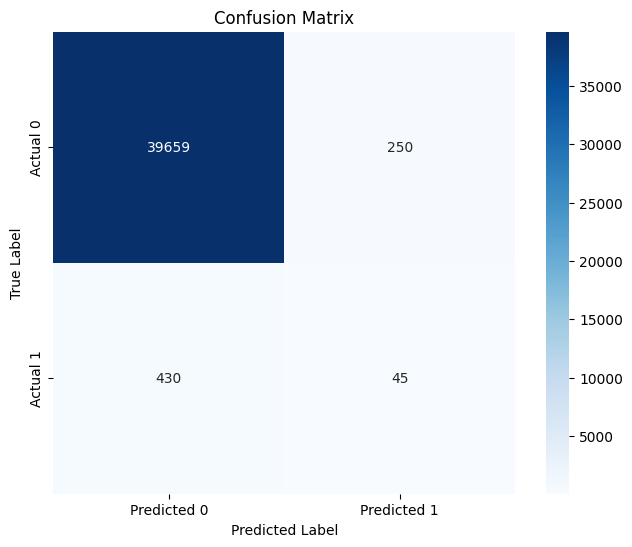

In [19]:
from sklearn.svm import SVC

# SVMモデルを定義して訓練します
svm = SVC(kernel='rbf', C=1000, random_state=0) #linearは遅すぎ
svm.fit(X_train_scaled, y_train)

# テストデータで予測を行います
y_pred = svm.predict(X_test_scaled)

# 分類結果の評価
print("Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# 混同行列をヒートマップとして表示します
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=True, square=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


